# Tweaking the Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# needs python 2
# import graphlab as gl
# gl.canvas.set_target('ipynb')

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from src import EDA
from src import ModelEvaluation
%load_ext autoreload
%autoreload 2

In [2]:
steam_df = EDA.load_without_cold_start(5)
steam_df = steam_df[steam_df['purchase_action'] == 'play']
steam_df["playtime_rank"] = steam_df['playtime'].map(lambda value: EDA.rank_playtime(value))
steam_df = EDA.get_uids(steam_df, from_column='game_name', to_column='game_uid')
steam_df.head(2)

/Users/michaelbarton/Code/gproject/src/EDA.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return filtered_users[steam_df['game_name'].isin(usable_games['game_name'].values)]


,uid,game_name,purchase_action,playtime,playtime_rank,game_uid
1,151603712,The Elder Scrolls V Skyrim,play,273.0,3,0
3,151603712,Fallout 4,play,87.0,3,1


In [3]:
# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()
# Convert a Pandas DF to a Spark DF
spark_df = spark.createDataFrame(steam_df)
spark_df.count()
train, test = spark_df.randomSplit([0.8, 0.2], seed=427471138)
print('Training size: ', train.count())
print('Test size: ', test.count())

IllegalArgumentException: "Error while instantiating 'org.apache.spark.sql.hive.HiveSessionStateBuilder':"

In [5]:
als_model = ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_rank',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
)

paramGrid = ParamGridBuilder() \
    .addGrid(als_model.rank, [7,8,9,11,12]) \
    .build()
    
evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_rank") \
    .setPredictionCol("prediction")

In [6]:
tvs = TrainValidationSplit(estimator=als_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          trainRatio=0.8)

cvModel = tvs.fit(train)

NameError: name 'train' is not defined

In [54]:
predictions = cvModel.transform(test)
evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_rank") \
    .setPredictionCol("prediction")
rmse = evaluator.evaluate(predictions)
rmse

als_model = ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_rank',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=10,
    maxIter=20,
) 

fitted_als_model = als_model.fit(train)

1.0112025828121356

### Max Iterations

In [4]:
als_model = ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_rank',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=10,
    maxIter=20,
) 

fitted_als_model = als_model.fit(train)

In [6]:
predictions = fitted_als_model.transform(test)

In [7]:
# predictions = fitted_als_model.transform(test)
evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_rank") \
    .setPredictionCol("prediction")
rmse = evaluator.evaluate(predictions)
rmse
# 1.0051786784416223 with maxIter = 10..

1.0069301894654907

# Graphing parameters

In [61]:
rmses = []
ranks = list(range(4,14))

# base, validation

for rank in ranks:
    als_model = ALS(
        itemCol='game_uid',
        userCol='uid',
        ratingCol='playtime_rank',
        nonnegative=True,    
        regParam=0.1,
        coldStartStrategy="drop", # Drops if user or item in test was not in train
        rank=rank) 

    fitted_als_model = als_model.fit(train)
    predictions = fitted_als_model.transform(test)
    evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_rank") \
    .setPredictionCol("prediction")
    rmse = evaluator.evaluate(predictions)
    rmses.append(rmse)

/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


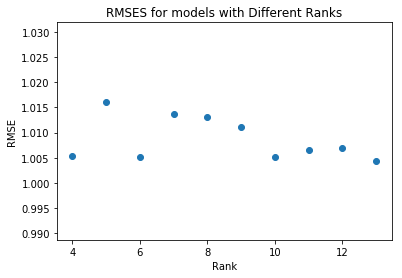

In [62]:
fig, ax = plt.subplots()
ax.scatter(ranks, rmses)
ax.set_title('RMSES for models with Different Ranks')
ax.set_xlabel('Rank')
ax.set_ylabel('RMSE')
fig.show()

In [63]:
rmses = []
ranks = list(range(13,30))

# base, validation

for rank in ranks:
    als_model = ALS(
        itemCol='game_uid',
        userCol='uid',
        ratingCol='playtime_rank',
        nonnegative=True,    
        regParam=0.1,
        coldStartStrategy="drop", # Drops if user or item in test was not in train
        rank=rank) 

    fitted_als_model = als_model.fit(train)
    predictions = fitted_als_model.transform(test)
    evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_rank") \
    .setPredictionCol("prediction")
    rmse = evaluator.evaluate(predictions)
    rmses.append(rmse)

/Users/michaelbarton/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


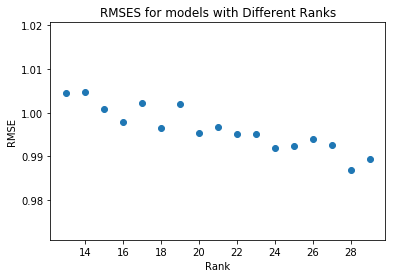

In [64]:
fig, ax = plt.subplots()
ax.scatter(ranks, rmses)
ax.set_title('RMSES for models with Different Ranks')
ax.set_xlabel('Rank')
ax.set_ylabel('RMSE')
fig.show()